In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [3]:
import numpy as np
import tensorflow as tf
import sentencepiece as spm

import tensorflow.keras.backend as K

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
valid_data = tf.data.TextLineDataset('sequences_train_subset.txt')

In [6]:
for ex in valid_data.take(1):
    print(ex)

tf.Tensor(b'MAKRKGKTYLSVLILVLIAILIFFISRLSIFEKNTPQILMPDVVYTDLKKPILVHVKDDESSIKNVQIILHKDDNTSAMVIADEKISNLKDITLQVALPKFGYKENVKSFVLEVIAKDSSFWNFFSGNEARKQIAVLVDNTAPKINIISNSYQIEQGGAGAVVFKADDANLDKVYIETNKGKIFKATPYVKEGYYAALIAWDARDEEFRAFVIATDKAGNISKERIRYYFVNRKYRVSNINLTDKFLDGKIENLANQYAPKDNNLNRYEKFKFVNETLRNSNEKLIHEITSKVPEEKIDNFDLNLFLPLKNGMKVADFADHRYYSYNGQFVSDSYHMGLDLASVAQAPIISNNAGKVVFAAENGIYGLNLIVYHGFGVYSLYGHCSSKNVDLDEMINKQSIIGKTGTSGLALGDHLHFGVLVQGVETRPEQWQDKKWIENNIYNVLNDGKKIILGKN', shape=(), dtype=string)


In [9]:
sp = spm.SentencePieceProcessor()
sp.Load("sentencepiece_models/uniparc_5M.model")
# sp.load_vocabulary("/projects/bpms/pstjohn/uniparc/uniparc_5M.vocab", threshold=1)  # ??

True

In [10]:
import pandas as pd

In [11]:
MASK_INDEX = sp['[MASK]']  #replace
VOCAB_SIZE = 32000
VOCAB_START = 5
MAX_ENCODED_LENGTH = 512

def sp_encode(line_tensor):
    encoded_array = np.asarray(sp.SampleEncodeAsIds(line_tensor.numpy(), nbest_size=-1, alpha=0.5))
    if len(encoded_array) > MAX_ENCODED_LENGTH:
        offset = np.random.randint(low=0, high=len(encoded_array) - MAX_ENCODED_LENGTH + 1)
        encoded_array = encoded_array[offset:(offset + MAX_ENCODED_LENGTH)]
    return encoded_array

def sp_decode(line_tensor):
    return sp.DecodeIds(line_tensor.numpy().tolist())

def sp_encode_tf(line_tensor):
    return tf.py_function(sp_encode, inp=[line_tensor], Tout=[tf.int32,])


def mask_input(input_tensor):
    """ Randomly mask the input tensor according to the formula perscribed by BERT. 
    Randomly masks 15% of input tokens, with 80% recieving the [MASK] token,
    10% randomized, 10% left unchanged. 
    
    Returns
    -------
    
    masked_tensor: (batch_size, seq_length) 
        Tensor with masked values
    input_tensor: (batch_size, seq_length)
        Original input tensor (true values)
    input_mask: (batch_size, seq_length)
        Boolean mask that selects the desired inputs.    
    """

    mask_score = tf.random.uniform(input_tensor.shape, maxval=1, dtype=tf.float32)
    input_mask = mask_score < .15
    true_values = input_tensor[input_mask]

    # Mask with [MASK] token 80% of the time
    mask_mask = mask_score <= 0.15 * 0.8 

    # Mask with random token 10% of the time
    mask_random = (mask_score >= 0.15 * 0.9) & input_mask

    # Tensors to replace with where input is masked or randomized
    mask_value_tensor = tf.ones(input_tensor.shape, dtype=tf.int32) * MASK_INDEX
    random_value_tensor = tf.random.uniform(
        input_tensor.shape, minval=VOCAB_START, maxval=VOCAB_SIZE, dtype=tf.int32)
    pad_value_tensor = tf.zeros(input_tensor.shape, dtype=tf.int32)

    # Use the replacements to mask the input tensor
    masked_tensor = tf.where(mask_mask, mask_value_tensor, input_tensor)
    masked_tensor = tf.where(mask_random, random_value_tensor, masked_tensor)
    
    # Set true values to zero (pad value) where not masked
    true_tensor = tf.where(input_mask, input_tensor, pad_value_tensor)

    return masked_tensor, true_tensor

def mask_input_tf(input_tensor):
    return tf.py_function(mask_input, inp=[input_tensor], Tout=[tf.int32, tf.int32])

In [12]:
encoded_data = valid_data\
                        .map(sp_encode_tf, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                        .map(mask_input_tf, num_parallel_calls=tf.data.experimental.AUTOTUNE)

encoded_data = encoded_data.shuffle(buffer_size=1024).padded_batch(20, padded_shapes=([-1], [-1]))

masked_seqs, true_values = next(iter(encoded_data))

In [13]:
masked_seqs

<tf.Tensor: id=61055, shape=(20, 314), dtype=int32, numpy=
array([[  328, 25050,   130, ...,     0,     0,     0],
       [   23,     7,  1672, ...,     0,     0,     0],
       [  486,    29,    17, ...,     0,     0,     0],
       ...,
       [ 6740,   310,     8, ...,     0,     0,     0],
       [   23,     7,  2114, ...,     0,     0,     0],
       [   23,     4,    78, ...,     0,     0,     0]], dtype=int32)>

In [14]:
true_values

<tf.Tensor: id=61056, shape=(20, 314), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 8, 0, ..., 0, 0, 0]], dtype=int32)>

## BERT layers development

In [15]:
from tensorflow.keras import layers

In [16]:
initializer = lambda: tf.keras.initializers.TruncatedNormal(stddev=0.02)

class PositionEmbedding(layers.Embedding):
    """ Return masked embeddings according to the position index of each input """
        
    def call(self, inputs, *args, **kwargs):
        idx = tf.cast(tf.where(inputs != 0), dtype=tf.int32)
        padded_position_indicies = tf.scatter_nd(idx, idx[:, 1] + 1, tf.shape(inputs))
        return super(PositionEmbedding, self).call(padded_position_indicies)

embedding = PositionEmbedding(MAX_ENCODED_LENGTH + 1, MAX_ENCODED_LENGTH, mask_zero=True)
assert np.all(embedding(masked_seqs)[0, 2, :] == embedding(masked_seqs)[5, 2, :])

In [17]:
inputs = embedding(masked_seqs)

In [18]:
inputs._keras_mask

<tf.Tensor: id=61123, shape=(20, 314), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

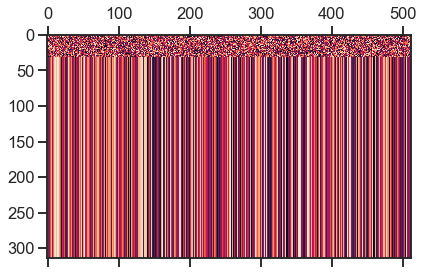

In [19]:
plt.matshow(embedding(masked_seqs)[1])

In [20]:
import numpy as np
import tensorflow as tf

def gelu(x):
    """
    Gelu activation from arXiv:1606.08415.
    """
    cdf = 0.5 * (1.0 + tf.tanh(gelu._const * (x + 0.044715 * tf.pow(x, 3))))
    return x * cdf

gelu._const = np.sqrt(2.0 / np.pi)


class Attention(layers.Layer):
    """ Implements a single head of the multi-head attention transformer model.
    Includes the preceeding dense layers on the value, key, and query matrices
    """

    def __init__(self, units, dropout=0.1, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.units = units
        self.dropout = dropout
        
    def build(self, input_shape):       
        self.query_layer = layers.Dense(
            self.units, kernel_initializer=initializer(), name='query')
        self.key_layer = layers.Dense(
            self.units, kernel_initializer=initializer(), name='key')
        self.value_layer = layers.Dense(
            self.units, kernel_initializer=initializer(), name='value')
        self.dropout_layer = layers.Dropout(self.dropout)
        
    def create_attention_mask(self, input_mask):
        mask = tf.cast(input_mask, tf.float32)
        return tf.linalg.einsum('aj,ak->ajk', mask, mask)
        
    def call(self, inputs, mask=None, training=None):
        query = self.query_layer(inputs)
        key   = self.key_layer(inputs)
        value = self.value_layer(inputs)
        
        # Equation 1 of "Attention is all you need"
        attention_scores = (tf.matmul(query, key, transpose_b=True) 
                            / tf.sqrt(float(self.units)))

        # zero out masked values
        attention_mask = self.create_attention_mask(mask)
        attention_scores = attention_scores + (1. - attention_mask) * -10000.0
        
        attention_probs = tf.nn.softmax(attention_scores)
        attention_probs = self.dropout_layer(attention_probs, training=training)
        context_layer = tf.matmul(attention_probs, value)
        
        return context_layer

    def compute_mask(self, inputs, mask=None):
        return mask

    def get_config(self):
        config = super(Attention, self).get_config()
        config.update({'units': self.units, 'dropout': self.dropout})
        return config
    
    
inputs = embedding(masked_seqs)
out = Attention(8, name='test')(inputs)
out.shape

TensorShape([20, 314, 8])

In [21]:
out._keras_mask

<tf.Tensor: id=61157, shape=(20, 314), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

In [27]:
class Projection(layers.Layer):
    """ Performs a dense layer, dropout, layer norm and residual update """
    def __init__(self, units, dropout=0.1, **kwargs):
        super(Projection, self).__init__(**kwargs)        
        self.units = units
        self.dropout = dropout        

    def build(self, input_shape):
        self.dense_layer = layers.Dense(self.units,
                                        kernel_initializer=initializer(),
                                        activation=gelu)
        self.dropout_layer = layers.Dropout(self.dropout)
        self.layer_norm = layers.LayerNormalization()

    def call(self, inputs, training=None):
        output, residual = inputs
        output = self.dense_layer(output)
        output = self.dropout_layer(output, training=training)
        return self.layer_norm(output + residual)

    def get_config(self):
        config = super(Projection, self).get_config()
        config.update({'units': self.units, 'dropout': self.dropout})
        return config


class Transformer(layers.Layer):
    """ Performs the multi-headed attention and normalization of a single
    transformer block """

    def __init__(self, num_heads, intermediate_units, dropout=0.1, **kwargs):
        super(Transformer, self).__init__(**kwargs)        
        self.num_heads = num_heads
        self.dropout = dropout
        self.intermediate_units = intermediate_units
        
        
    def build(self, input_shape):

        # Split the model dimension equally amoung attention heads
        d_model = input_shape[-1]
        assert d_model % self.num_heads == 0, \
            f"input dimension {d_model} not divisible by {self.num_heads} "\
            "attention heads"
        
        self.units = d_model // self.num_heads
        
        self.attention_heads = [
            Attention(self.units, self.dropout, name='head_{}'.format(i))
            for i in range(self.num_heads)]
        
        self.intermediate_layer = layers.Dense(self.intermediate_units,
                                               kernel_initializer=initializer(),
                                               activation=gelu)
        
        self.attention_projection = Projection(self.units, self.dropout,
                                               name='attention_projection')
        self.output_projection = Projection(self.units, self.dropout,
                                            name='output_projection')


    def call(self, inputs, mask=None, training=None):
        
        # Multi-head attention block
        attention_output = tf.concat([attention_layer(inputs, mask=mask) for
                                      attention_layer in self.attention_heads],
                                     axis=-1)
        attention_output = self.attention_projection([attention_output, inputs])
        
        intermediate_values = self.intermediate_layer(attention_output)
        output = self.output_projection([intermediate_values, attention_output])
        return output
    
    def compute_mask(self, inputs, mask=None):
        return mask 

    def get_config(self):
        config = super(Transformer, self).get_config()
        config.update({'num_heads': self.num_heads,
                       'intermediate_units': self.intermediate_units,
                       'dropout': self.dropout})
        return config
        
inputs = embedding(masked_seqs)
transformer = Transformer(8, 1024, 0.1, name='test')

In [36]:
inputs.shape

TensorShape([20, 314, 512])

In [37]:
attention_output.shape

TensorShape([20, 314, 512])

In [40]:
attention_output = tf.concat([attention_layer(inputs) for
                              attention_layer in transformer.attention_heads],
                             axis=-1)

output, residual = attention_output, inputs
output = transformer.attention_projection.dense_layer(output)

In [41]:
output.shape

TensorShape([20, 314, 64])

In [39]:
attention_output = transformer.attention_projection([attention_output, inputs])

InvalidArgumentError: Incompatible shapes: [20,314,64] vs. [20,314,512] [Op:AddV2] name: attention_projection/add/

TensorShape([20, 314, 512])

In [30]:
out = transformer(inputs)
out2 = transformer(out)

InvalidArgumentError: Incompatible shapes: [20,314,64] vs. [20,314,512] [Op:AddV2] name: test/attention_projection/add/

AttributeError: 'Transformer' object has no attribute 'attention_heads'

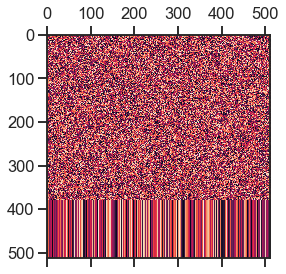

In [20]:
plt.matshow(out2[0])

## Build the BERT model

In [21]:
class Classifier(layers.Layer):
    
    def __init__(self, embedding_weights, **kwargs):
        super(Classifier, self).__init__(**kwargs)
        self.embedding_weights = embedding_weights
        
    def build(self, input_shape):
        
        self.dense = layers.Dense(
            self.embedding_weights.shape[1], 
            kernel_initializer=initializer(), activation=gelu)
        
        self.bias = self.add_weight(name='classifier_bias',
                                    dtype=K.floatx(),
                                    shape=[self.embedding_weights.shape[0]],
                                    initializer=tf.zeros_initializer())
        
    def call(self, inputs):
        logits = self.dense(inputs)
        logits = tf.matmul(logits, self.embedding_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, self.bias)
        return logits
        
    def compute_mask(self, inputs, mask=None):
        return None

In [22]:
from bert.layers import TokenEmbedding, Bias

inputs = layers.Input(shape=(None,), dtype=tf.int32, batch_size=None)

vocab_size = 32000
max_seq_len = 512
embedding_dimension = 128
model_dimension = 1024
num_attention_heads = model_dimension // 64
num_transformer_layers = 12
dropout_rate = 0.1


token_embedding_layer = TokenEmbedding(
    vocab_size, embedding_dimension, embeddings_initializer=initializer(), mask_zero=True)
token_embeddings = token_embedding_layer(inputs)
position_embeddings = PositionEmbedding(
    MAX_ENCODED_LENGTH + 1, embedding_dimension, embeddings_initializer=initializer(), mask_zero=True)(inputs)

embeddings = layers.Add()([token_embeddings, position_embeddings])
embeddings = layers.Dense(model_dimension)(embeddings)

transformer = Transformer(num_attention_heads)
for i in range(num_transformer_layers):
    embeddings = transformer(embeddings)
    
# output = Classifier(token_embedding_layer.embeddings)(embeddings)
out = layers.Dense(embedding_dimension, activation=gelu, kernel_initializer=initializer())(embeddings)
out = token_embedding_layer(out, transpose=True)
out = Bias()(out)
# output = DenseClearMask(vocab_size, kernel_initializer=initializer())(embeddings)

bert = tf.keras.Model([inputs], [output], name='bert')
bert.summary()

Model: "bert"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
token_embedding (TokenEmbedding multiple             128000      input_1[0][0]                    
                                                                 dense_3[0][0]                    
__________________________________________________________________________________________________
position_embedding_1 (PositionE (None, None, 4)      2052        input_1[0][0]                    
__________________________________________________________________________________________________
add (Add)                       (None, None, 4)      0           token_embedding[0][0]         

In [23]:
bert_out = bert(masked_seqs)

In [24]:
bert_out.shape

TensorShape([20, 512, 32000])

In [25]:
# y_true = true_values
# y_pred = bert_out

# idx = tf.cast(tf.where(y_true != 0), dtype=tf.int32)
# y_pred_mask = tf.boolean_mask(y_pred, y_true != 0)
# y_true_mask = tf.boolean_mask(y_true, y_true != 0)

# crossentropy_losses = tf.nn.sparse_softmax_cross_entropy_with_logits(
#     y_true_mask,
#     y_pred_mask)

# tf.scatter_nd(idx, crossentropy_losses, tf.shape(y_true))

In [26]:
def masked_sparse_cross_entropy_loss(y_true, y_pred):
    """ Computes the mean categorical cross_entropy loss across each batch example,
    where masked or randomized tokens are specified by nonzero entries in y_true """
    
    idx = tf.where(y_true != 0)
    y_pred_mask = tf.boolean_mask(y_pred, y_true != 0)
    y_true_mask = tf.boolean_mask(y_true, y_true != 0)

    crossentropy_losses = tf.nn.sparse_softmax_cross_entropy_with_logits(
        y_true_mask,
        y_pred_mask)

    return tf.reshape(tf.math.segment_mean(crossentropy_losses, idx[:, 0]), (-1, 1))


In [27]:
true_labels = layers.Input(shape=(None,), dtype=tf.int32, batch_size=None)
bert.compile(loss=masked_sparse_cross_entropy_loss, target_tensors=true_labels, optimizer=tfa.optimizers.AdamW(weight_decay=0.01, learning_rate=1E-3))

In [28]:
from tensorflow.keras.callbacks import Callback
    
class BERTLearningRateScheduler(Callback):
    def __init__(self, 
                 initial_learning_rate=1E-4,
                 final_learning_rate=0,
                 num_warmup_steps=int(1E3),
                 num_training_steps=int(1E6)):
        """ Implements the linear learning rate warmup and linear learning rate
        decay used by google in BERT pretraining """
        
        self.initial_learning_rate = initial_learning_rate
        self.final_learning_rate = final_learning_rate
        self.num_warmup_steps = num_warmup_steps
        self.num_training_steps = num_training_steps
        self.global_step = 0
        
    def on_train_batch_begin(self, batch, logs=None):
        
        self.global_step += 1
        
        # Still in warmup
        if self.global_step <= self.num_warmup_steps:
            scheduled_lr = self.initial_learning_rate * (
                self.global_step / self.num_warmup_steps)
        
        # Linear decay
        else:
            scheduled_lr = self.initial_learning_rate - self.global_step * (
                (self.initial_learning_rate - self.final_learning_rate) /
                (self.num_training_steps - self.num_warmup_steps))
            
        K.set_value(self.model.optimizer.lr, scheduled_lr)

In [29]:
bert.fit(encoded_data, epochs=50, callbacks=[BERTLearningRateScheduler()], verbose=1)

Epoch 1/50


/Users/pstjohn/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ValueError: Variable <tf.Variable 'transformer/head_0/query/kernel:0' shape=(16, 8) dtype=float32> has `None` for gradient. Please make sure that all of your ops have a gradient defined (i.e. are differentiable). Common ops without gradient: K.argmax, K.round, K.eval.

In [ ]:
bert.save('test_save', save_format='tf')

In [ ]:
eval_data = valid_data.map(sp_encode_tf, num_parallel_calls=tf.data.experimental.AUTOTUNE).padded_batch(60, padded_shapes=([512],))
eval_encoded = next(iter(eval_data))

In [ ]:
bert_predict = bert.predict(eval_encoded)

In [ ]:
bert_predict.shape